# Анализ шума для задачи регрессии

## Построение fft для отдельных отрезков записи

In [ ]:
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy.fft import fft
from scipy.stats import pearsonr
from scipy.optimize import minimize
from tqdm import tqdm
import matplotlib.pyplot as plt
from os import path
import fft_analysis_func
import os

In [ ]:
raw_data_path = '/'
target_data_file_name = 'target_data.csv'
noise_data_file_name = 'noise.wav'
output_path = path.join('preprocessed_data')
output_file_name = 'fft_for_samples.csv'
max_freq=20000 # максимальная частота
freq_step = 1 # шаг частот для fft
segment_length=10 # длина отрезка в секундах

In [ ]:
sample_rate, noise_data = wavfile.read(path.join(raw_data_path, noise_data_file_name))

In [ ]:
sample_rate, noise_data = fft_analysis_func.load_noise_data(path.join(raw_data_path, noise_data_file_name), normalize=True)
print('Длительность ', len(noise_data) // sample_rate //60)

Duration  135


In [ ]:
def compute_fft_for_segments_step(
    audio_data,
    sample_rate,
    segment_length=10,
    max_freq=20000,
    freq_step=1,
    save_path=None,
    dtype="float32"
):
    """
    Вычисляет БПФ для аудио отрезков.
    """
    if len(audio_data.shape) == 2:
        audio_data = audio_data.mean(axis=1)
    
    segment_samples = int(segment_length * sample_rate)
    num_segments = len(audio_data) // segment_samples
    
    if num_segments == 0:
        raise ValueError("Аудио короче чем segment_length")
    
    all_freqs = np.fft.fftfreq(segment_samples, 1/sample_rate)

    positive_mask = (all_freqs >= 0) & (all_freqs <= max_freq)
    positive_freqs = all_freqs[positive_mask]
    
    rounded_freqs = np.round(positive_freqs).astype(int)
    unique_freqs = np.unique(rounded_freqs)
    
    selected_freqs = unique_freqs[unique_freqs % freq_step == 0]
    
    freq_indices = []
    for freq in selected_freqs:
        idx = np.abs(positive_freqs - freq).argmin()
        freq_indices.append(np.where(positive_mask)[0][idx])
    
    freq_indices = np.array(freq_indices)
    
    if len(freq_indices) != len(selected_freqs):
        raise ValueError(
            f"Критическая ошибка: {len(freq_indices)} индексов != "
            f"{len(selected_freqs)} частот после преобразований"
        )

    columns = ['start', 'end'] + [f'freq_{f}' for f in selected_freqs]
    
    data = []
    for i in tqdm(range(num_segments)):
        start = i * segment_samples
        end = start + segment_samples
        segment = audio_data[start:end]
        
        full_fft = fft(segment)
        fft_values = np.abs(full_fft[freq_indices]).astype(dtype)
        row = [start/sample_rate, end/sample_rate] + fft_values.tolist()
        data.append(row)
    
    df = pd.DataFrame(data, columns=columns)
    
    if save_path is not None:
        df.to_csv(os.path.join(save_path, ), index=False)
            
    return df


In [ ]:
df = compute_fft_for_segments_step(
    audio_data=noise_data,
    sample_rate=sample_rate,
    segment_length=10,  
    max_freq=20000,
    freq_step=1,
    dtype="float32"
)
df.shape

100%|██████████| 813/813 [00:06<00:00, 133.56it/s]


(813, 20003)

In [ ]:
output_file_name = str(segment_length) + '_sec_' + str(freq_step) + '_Hz_step_' + output_file_name
df.to_csv(path.join(output_path, output_file_name), index=False)
print('Data is saved')

Data is saved


In [60]:
df.head()

,start,end,freq_0,freq_1,freq_2,freq_3,freq_4,freq_5,freq_6,freq_7,...,freq_19991,freq_19992,freq_19993,freq_19994,freq_19995,freq_19996,freq_19997,freq_19998,freq_19999,freq_20000
0,0.0,10.0,807.856262,686.730896,282.044952,309.818695,118.967957,86.875648,88.107475,11.557445,...,7.240552,3.029885,11.106122,4.210503,7.205020,6.477736,8.190432,7.101306,8.936485,6.669637
1,10.0,20.0,924.298584,520.436707,66.299126,101.954880,78.613922,125.146889,60.301018,55.631065,...,10.496044,4.237654,5.475031,5.452667,5.535171,6.051291,18.791582,1.885246,7.084495,5.540395
2,20.0,30.0,374.887329,358.244965,149.762665,156.356995,127.107216,103.695526,171.486160,43.380745,...,9.207145,6.592286,5.773502,9.969880,11.169580,2.619894,6.978531,5.565591,3.848150,1.951997
3,30.0,40.0,949.030762,1495.328857,387.119568,152.818573,124.776917,124.147522,19.639866,67.056519,...,9.831748,6.454184,6.087955,3.746695,4.636087,4.052964,5.666633,1.378837,6.810756,12.985419
4,40.0,50.0,1313.751221,419.747772,188.000244,155.365387,112.028511,32.888638,55.218735,35.462154,...,8.348808,12.067417,5.827291,3.905603,4.288909,4.293678,2.685843,16.734343,7.301071,6.499936


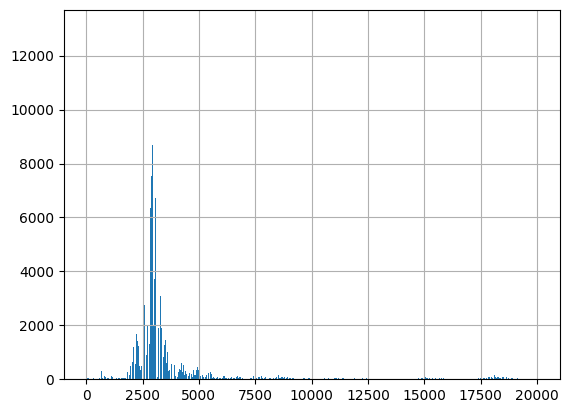

In [61]:
freqs = np.arange(0, 20001)
freqs_data = df.iloc[0, 2:].tolist()
plt.bar(freqs, freqs_data)
plt.grid()

## Рассчет корреляций с целевыми переменными на разных частотных диапазонах

### Загрузка данных 

In [ ]:
target_data = pd.read_csv(path.join(raw_data_path, target_data_file_name))

In [ ]:
# убираем первое значение, для которого нет данных измерений
target1 = target_data['target1'].to_numpy()[1:]
target2 = target_data['target2'].to_numpy()[1:]

In [73]:
fft_data = pd.read_csv(path.join(output_path, output_file_name))
fft_data.head()

,start,end,freq_0,freq_1,freq_2,freq_3,freq_4,freq_5,freq_6,freq_7,...,freq_19991,freq_19992,freq_19993,freq_19994,freq_19995,freq_19996,freq_19997,freq_19998,freq_19999,freq_20000
0,0.0,10.0,807.856262,686.730896,282.044952,309.818695,118.967957,86.875648,88.107475,11.557445,...,7.240552,3.029885,11.106122,4.210503,7.205020,6.477736,8.190432,7.101306,8.936485,6.669637
1,10.0,20.0,924.298584,520.436707,66.299126,101.954880,78.613922,125.146889,60.301018,55.631065,...,10.496044,4.237654,5.475031,5.452667,5.535171,6.051291,18.791582,1.885246,7.084495,5.540395
2,20.0,30.0,374.887329,358.244965,149.762665,156.356995,127.107216,103.695526,171.486160,43.380745,...,9.207145,6.592286,5.773502,9.969880,11.169580,2.619894,6.978531,5.565591,3.848150,1.951997
3,30.0,40.0,949.030762,1495.328857,387.119568,152.818573,124.776917,124.147522,19.639866,67.056519,...,9.831748,6.454184,6.087955,3.746695,4.636087,4.052964,5.666633,1.378837,6.810756,12.985419
4,40.0,50.0,1313.751221,419.747772,188.000244,155.365387,112.028511,32.888638,55.218735,35.462154,...,8.348808,12.067417,5.827291,3.905603,4.288909,4.293678,2.685843,16.734343,7.301071,6.499936


### Target 1. Окна в 500 Гц с перекрытием 250

In [ ]:
def select_fft_slice(df, t1, t2, w1, w2):
    """
    Выбирает срез из DataFrame с результатами БПФ по заданным временному и частотному диапазонам.
    """
    time_filtered = df[(df['start'] >= t1) & (df['end'] <= t2)].copy()
    
    if time_filtered.empty:
        raise ValueError(f"Нет данных в временном диапазоне {t1}-{t2} секунд")

    freq_columns = [col for col in df.columns if col.startswith('freq_')]

    freq_values = [int(col.split('_')[1]) for col in freq_columns]

    selected_freq_cols = [
        col for col, freq in zip(freq_columns, freq_values) 
        if w1 <= freq <= w2
    ]
    
    if not selected_freq_cols:
        raise ValueError(f"Нет данных в частотном диапазоне {w1}-{w2} Гц")
    
    result = pd.concat([
        time_filtered[['start', 'end']],
        time_filtered[selected_freq_cols]
    ], axis=1)
    
    return result


def calculate_band_correlations(df_fft, target_values, min_freq=0, max_freq=20000, bandwidth=500, overlap=250, segment_length=10, measurement_interval=60):
    """
    Вычисляет корреляции между целевой переменной и центроидами шума на различных полосах пропускания.
    """

    total_moise_measurement_intervals = int(df_fft['end'].max() // measurement_interval)
    target_len_intervals = len(target_values)

    if target_len_intervals < total_moise_measurement_intervals:
        print(f"Предупреждение: значений целевой переменной ({target_len_intervals}) меньше чем инетрвалов в записи в записи ({total_moise_measurement_intervals}). Обрезаем запись.")
        max_time = target_len_intervals * measurement_interval
        df_fft = df_fft[df_fft['end'] <= max_time].copy()
    elif target_len_intervals > total_moise_measurement_intervals:
        print(f"Предупреждение: значений целевой переменной ({target_len_intervals}) больше чем интервалов в записи ({total_moise_measurement_intervals}). Обрезаем целевую переменную.")
        target_values = target_values[:total_moise_measurement_intervals]
    
    bands = []
    current_min = min_freq
    while current_min < max_freq:
        bands.append((current_min, min(current_min + bandwidth, max_freq)))
        current_min += (bandwidth - overlap)
    
    results = []
    
    for band_min, band_max in tqdm(bands, desc="Анализ полос"):
        try:
            band_data = select_fft_slice(df_fft, t1=0, t2=df_fft['end'].max(), 
                                       w1=band_min, w2=band_max)

            interval_centroids = []
            valid_targets = []
            
            for interval_number in range(len(target_values)):
                interval_start = interval_number * measurement_interval
                interval_end = (interval_number + 1) * measurement_interval
                interval_segments = band_data[
                    (band_data['start'] >= interval_start) & 
                    (band_data['end'] <= interval_end)
                ]
                
                if len(interval_segments) != int(measurement_interval / segment_length):
                    continue
                
                freq_columns = [col for col in interval_segments.columns if col.startswith('freq_')]
                minute_avg = interval_segments[freq_columns].mean(axis=0).mean()
                interval_centroids.append(minute_avg)
                valid_targets.append(target_values[interval_number])
            
            if len(interval_centroids) >= 3:  # Минимум 3 точки для корреляции
                corr, p_value = pearsonr(valid_targets, interval_centroids)
                results.append({
                    'band_min': band_min,
                    'band_max': band_max,
                    'correlation': corr,
                    'p_value': p_value,
                    'center_freq': (band_min + band_max) / 2,
                    'n_samples': len(interval_centroids)
                })
                
        except ValueError as e:
            print(f"Ошибка при анализе полосы {band_min}-{band_max} Гц: {str(e)}")
            continue
    
    return pd.DataFrame(results)

In [ ]:
correlation_results = calculate_band_correlations(
        df_fft=fft_data,
        target_values=target1,
        min_freq=0,
        max_freq=20000,
        bandwidth=500,
        overlap=250
    )

Предупреждение: значений целевой переменной (132) меньше чем минут в записи (135). Обрезаем запись.


Анализ полос: 100%|██████████| 80/80 [00:11<00:00,  7.02it/s]


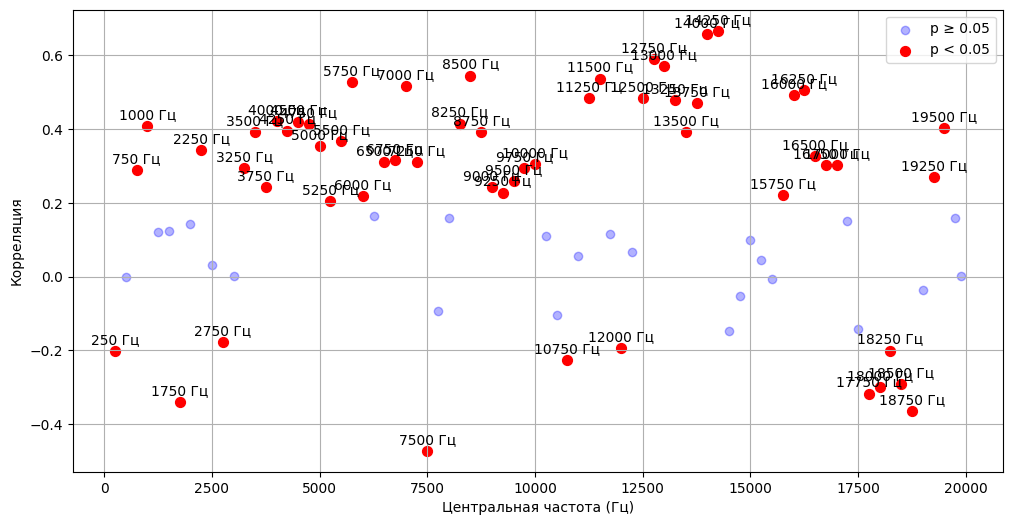

In [75]:
fft_analysis_func.plot_correlations(correlation_results, print_freq=True)

In [76]:
print(correlation_results.sort_values('correlation', ascending=False).head(10))

    band_min  band_max  correlation       p_value  center_freq  n_samples
56     14000     14500     0.666462  2.738305e-18      14250.0        132
55     13750     14250     0.657807  1.045120e-17      14000.0        132
50     12500     13000     0.590010  9.739695e-14      12750.0        132
51     12750     13250     0.570141  9.633225e-13      13000.0        132
33      8250      8750     0.544944  1.425134e-11       8500.0        132
45     11250     11750     0.536781  3.254301e-11      11500.0        132
22      5500      6000     0.527136  8.393517e-11       5750.0        132
27      6750      7250     0.517350  2.130259e-10       7000.0        132
64     16000     16500     0.506564  5.749601e-10      16250.0        132
63     15750     16250     0.493082  1.896327e-09      16000.0        132


### Target1. Окна в 100 Гц с перекрытием 50

In [ ]:
correlation_results = calculate_band_correlations(
        df_fft=fft_data,
        target_values=target1,
        min_freq=0,
        max_freq=20000,
        bandwidth=100,
        overlap=50)

Предупреждение: значений целевой переменной (132) меньше чем минут в записи (135). Обрезаем запись.


Анализ полос: 100%|██████████| 400/400 [00:45<00:00,  8.73it/s]


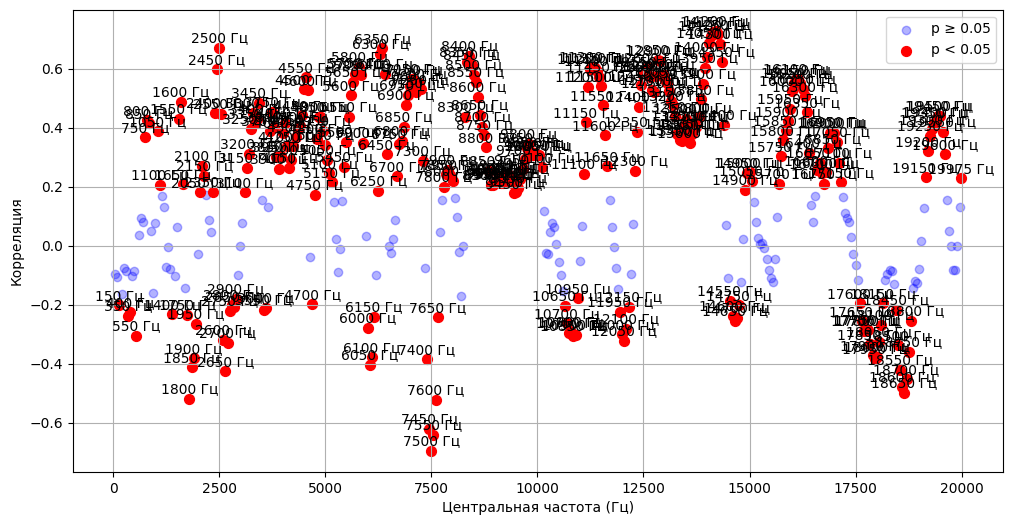

In [78]:
fft_analysis_func.plot_correlations(correlation_results, print_freq=True)

In [79]:
print(correlation_results.sort_values('correlation', ascending=False).head(10))

     band_min  band_max  correlation       p_value  center_freq  n_samples
283     14150     14250     0.728150  4.500687e-23      14200.0        132
282     14100     14200     0.723376  1.173188e-22      14150.0        132
284     14200     14300     0.716262  4.716016e-22      14250.0        132
281     14050     14150     0.710812  1.330714e-21      14100.0        132
280     14000     14100     0.686073  1.109028e-19      14050.0        132
285     14250     14350     0.683867  1.610835e-19      14300.0        132
49       2450      2550     0.671012  1.330008e-18       2500.0        132
126      6300      6400     0.668325  2.040400e-18       6350.0        132
125      6250      6350     0.650900  2.949928e-17       6300.0        132
167      8350      8450     0.642862  9.547484e-17       8400.0        132


### Target 1. Окна в 10 Гц с перекрытием 5

In [ ]:
correlation_results = calculate_band_correlations(
        df_fft=fft_data,
        target_values=target1,
        min_freq=0,
        max_freq=20000,
        bandwidth=10,
        overlap=5)

Предупреждение: значений целевой переменной (132) меньше чем минут в записи (135). Обрезаем запись.


Анализ полос: 100%|██████████| 4000/4000 [07:20<00:00,  9.08it/s]


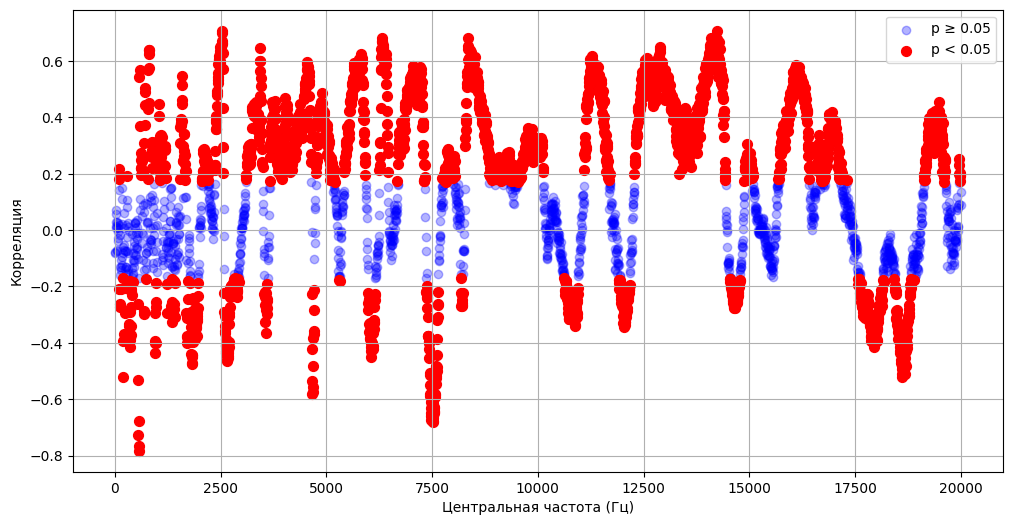

In [81]:
fft_analysis_func.plot_correlations(correlation_results)

### Target 2. Окна в 500 Гц с перекрытием 250

In [ ]:
correlation_results = calculate_band_correlations(
        df_fft=fft_data,
        target_values=target2,
        min_freq=0,
        max_freq=20000,
        bandwidth=500,
        overlap=250
    )

Предупреждение: значений целевой переменной (132) меньше чем минут в записи (135). Обрезаем запись.


Анализ полос: 100%|██████████| 80/80 [00:10<00:00,  7.30it/s]


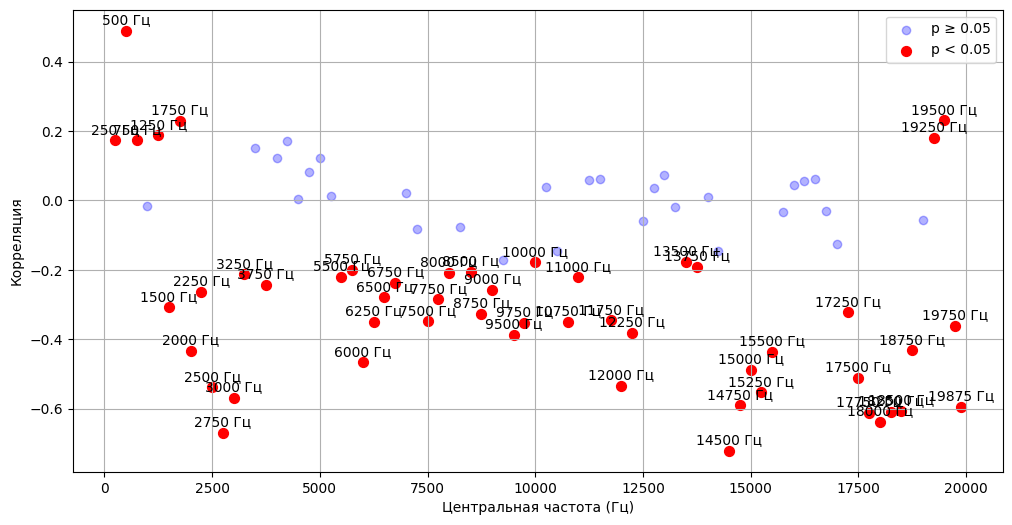

In [83]:
fft_analysis_func.plot_correlations(correlation_results, print_freq=True)

### Target 2. Окна в 100 Гц с перекрытием 50

In [ ]:
correlation_results = calculate_band_correlations(
        df_fft=fft_data,
        target_values=target2,
        min_freq=0,
        max_freq=20000,
        bandwidth=100,
        overlap=50
    )

Предупреждение: значений целевой переменной (132) меньше чем минут в записи (135). Обрезаем запись.


Анализ полос: 100%|██████████| 400/400 [00:45<00:00,  8.71it/s]


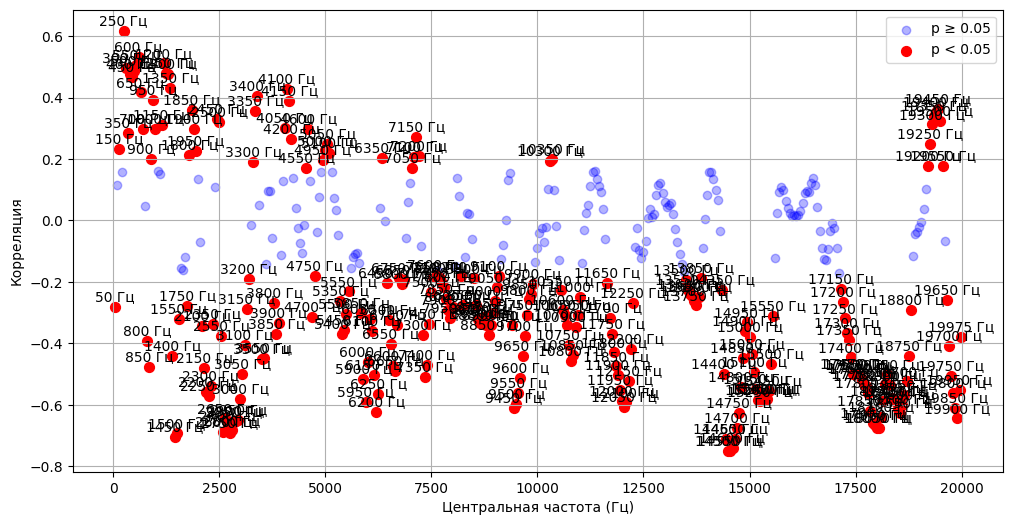

In [85]:
fft_analysis_func.plot_correlations(correlation_results, print_freq=True)

### Target 2. Окна в 10 Гц с перекрытием 5

In [ ]:
correlation_results = calculate_band_correlations(
        df_fft=fft_data,
        target_values=target2,
        min_freq=0,
        max_freq=20000,
        bandwidth=10,
        overlap=5
    )

Предупреждение: значений целевой переменной (132) меньше чем минут в записи (135). Обрезаем запись.


Анализ полос: 100%|██████████| 4000/4000 [07:11<00:00,  9.27it/s]


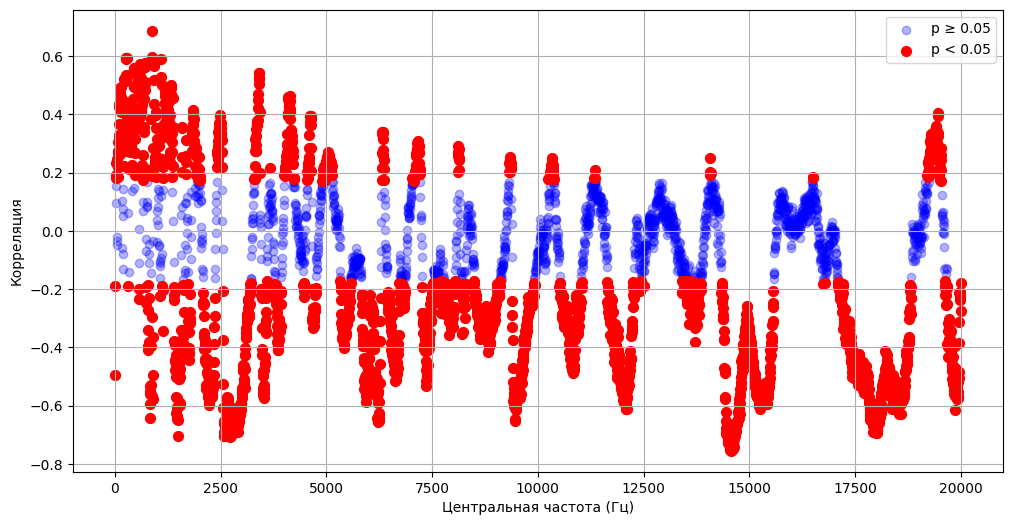

In [87]:
fft_analysis_func.plot_correlations(correlation_results)

## Сравнение целевой переменной и центроидов fft

### Target 1

На основе анализа корреляции рассмотрим диапазон 3750 - 4000 Гц.

In [ ]:
centroids_df = fft_analysis_func.calculate_minute_centroids(
        df_fft=fft_data,
        target_values=target1,
        freq_band=(3750, 4000)  # Можно сузить диапазон, например (500, 1000)
    )

Предупреждение: значений целевой переменной (132) меньше чем минут в записи (135). Обрезаем запись.


Расчёт центроидов: 100%|██████████| 132/132 [00:00<00:00, 956.09it/s]


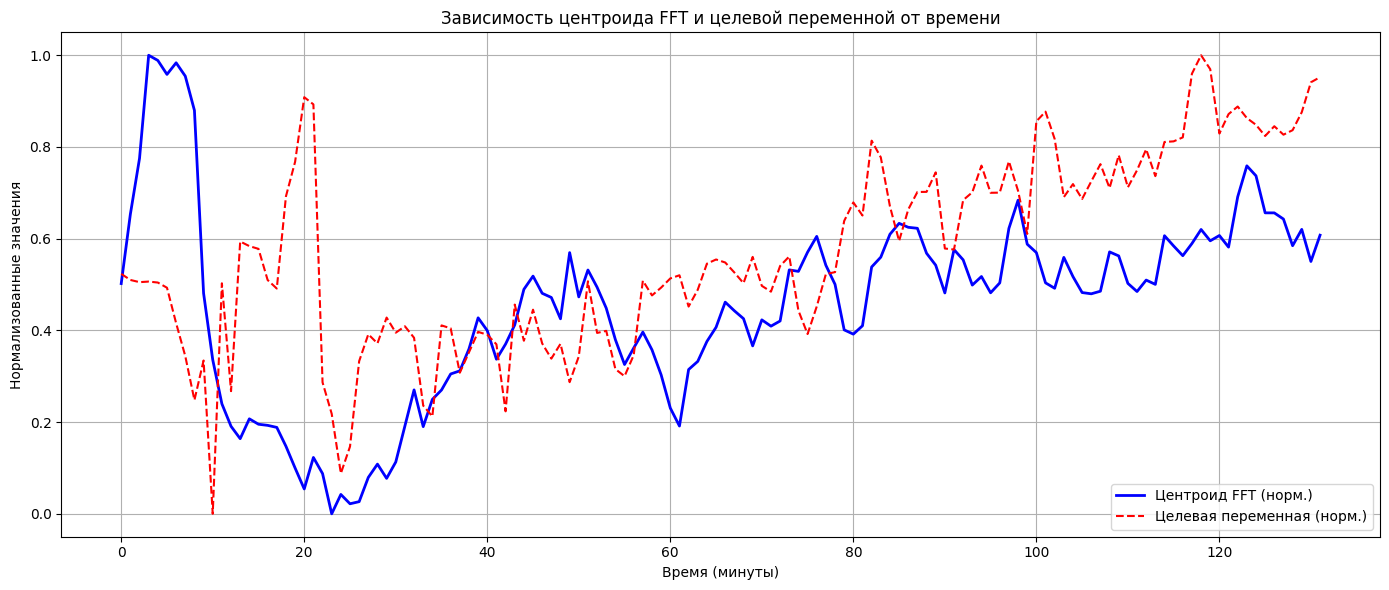

In [89]:
fft_analysis_func.plot_centroids_vs_target(centroids_df)

Видно наличие запаздывания

На основе анализа корреляции рассмотрим диапазон 12500 - 14000 Гц.

In [ ]:
centroids_df = fft_analysis_func.calculate_minute_centroids(
        df_fft=fft_data,
        target_values=target1,
        freq_band=(12500, 14000)  # Можно сузить диапазон, например (500, 1000)
    )

Предупреждение: значений целевой переменной (132) меньше чем минут в записи (135). Обрезаем запись.


Расчёт центроидов: 100%|██████████| 132/132 [00:00<00:00, 671.69it/s]


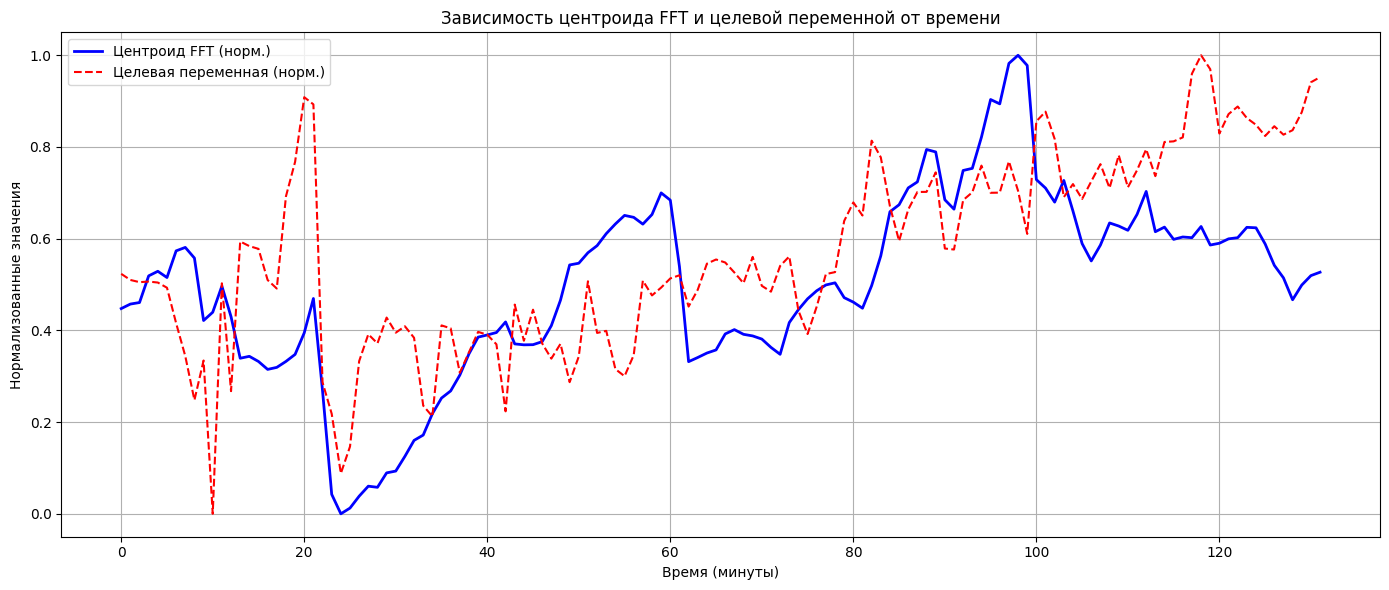

In [91]:
fft_analysis_func.plot_centroids_vs_target(centroids_df)

### Target 2

На основе анализа корреляции рассмотрим диапазон 2550 - 3000 Гц. Поскольку корреляция отрицательная, то будем инвертировать и сдвигать центроиды

In [ ]:
centroids_df = fft_analysis_func.calculate_minute_centroids(
        df_fft=fft_data,
        target_values=target2,
        freq_band=(2550, 3000)  # Можно сузить диапазон, например (500, 1000)
    )

Предупреждение: значений целевой переменной (132) меньше чем минут в записи (135). Обрезаем запись.


Расчёт центроидов: 100%|██████████| 132/132 [00:00<00:00, 880.85it/s]


In [131]:
centroids_df['centroid'] = -1 * centroids_df['centroid']  

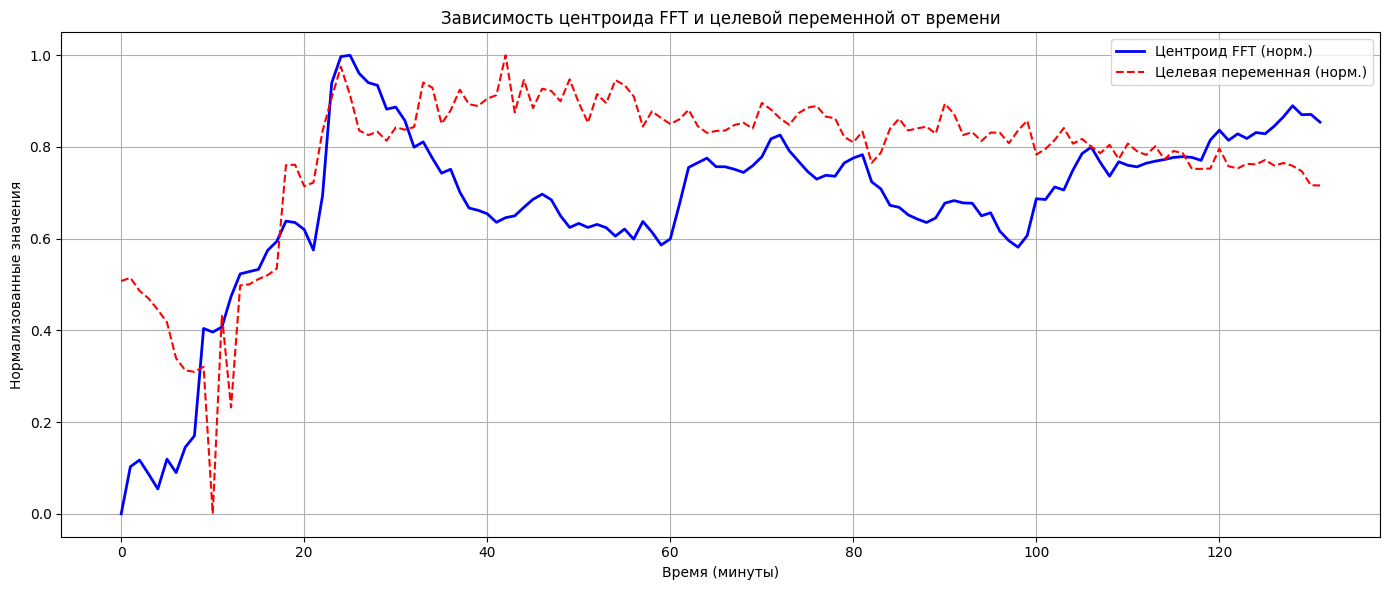

In [132]:
fft_analysis_func.plot_centroids_vs_target(centroids_df)

Также рассмотрим диапазон 17500-18700 Гц. На данных частотах нет явной корреляции с жидкостью.

In [ ]:
centroids_df = fft_analysis_func.calculate_minute_centroids(
        df_fft=fft_data,
        target_values=target2,
        freq_band=(17500, 18700)  # Можно сузить диапазон, например (500, 1000)
    )
centroids_df['centroid'] = -1 * centroids_df['centroid']  

Предупреждение: значений целевой переменной (132) меньше чем минут в записи (135). Обрезаем запись.


Расчёт центроидов: 100%|██████████| 132/132 [00:00<00:00, 725.07it/s]


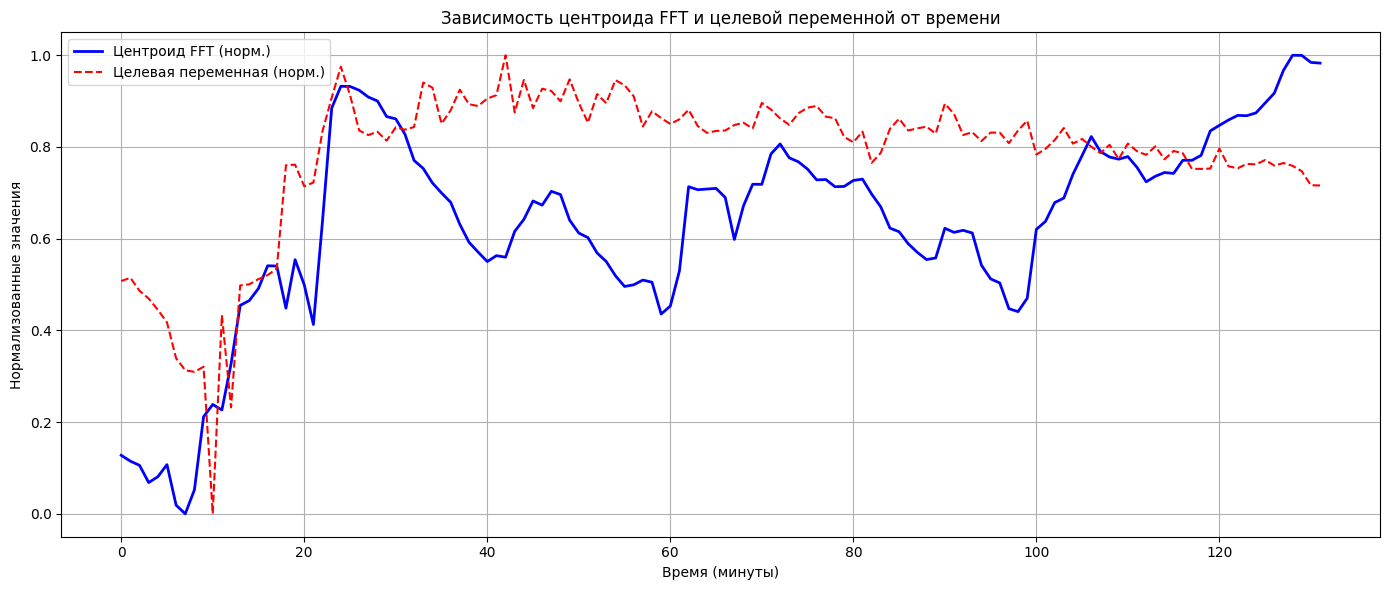

In [134]:
fft_analysis_func.plot_centroids_vs_target(centroids_df)

## Определение запаздывания

### Target 1

In [ ]:
centroids_df = fft_analysis_func.calculate_minute_centroids(
        df_fft=fft_data,
        target_values=target1,
        freq_band=(3750, 4000)  
    )
target_norm = (centroids_df['target'] - centroids_df['target'].min()) / (centroids_df['target'].max() -  centroids_df['target'].min())
centroid_norm = (centroids_df['centroid'] - centroids_df['centroid'].min()) / (centroids_df['centroid'].max() -  centroids_df['centroid'].min())
optimal_lag = 12
if optimal_lag == 0:
    shifted_centroid = centroid_norm
else:
    shifted_centroid = centroid_norm[:-optimal_lag]
shifted_centroid = np.concatenate([
        np.zeros(optimal_lag),
        shifted_centroid
    ])

Предупреждение: значений целевой переменной (132) меньше чем минут в записи (135). Обрезаем запись.


Расчёт центроидов: 100%|██████████| 132/132 [00:00<00:00, 880.91it/s]


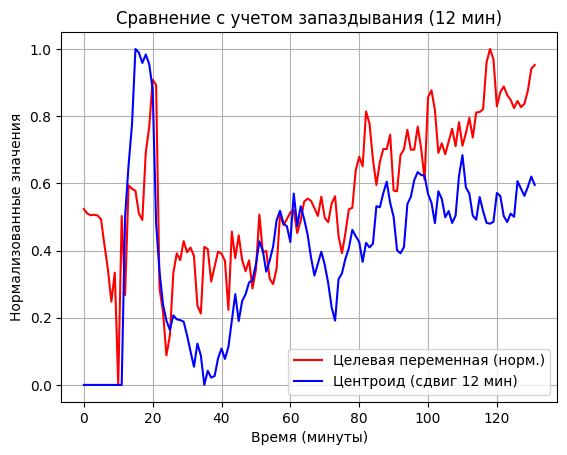

In [103]:
time = centroids_df['time']
plt.plot(time, target_norm, label='Целевая переменная (норм.)', color='red')
plt.plot(time, shifted_centroid, label=f'Центроид (сдвиг {optimal_lag} мин)', color='blue')
plt.xlabel('Время (минуты)')
plt.ylabel('Нормализованные значения')
plt.title(f'Сравнение с учетом запаздывания ({optimal_lag} мин)')
plt.legend()
plt.grid()

In [104]:
corr, p_value = pearsonr(target_norm, shifted_centroid)
print('Корреляция с учетом сдвига:', corr)
print('p-value:', p_value)

Корреляция с учетом сдвига: 0.6183448475767599
p-value: 2.7924257847126813e-15


### Target 2

In [ ]:
centroids_df = fft_analysis_func.calculate_minute_centroids(
        df_fft=fft_data,
        target_values=target2,
        freq_band=(14550, 14550)  # Можно сузить диапазон, например (500, 1000)
    )
centroids_df['centroid'] = -1 * centroids_df['centroid']  
target_norm = (centroids_df['target'] - centroids_df['target'].min()) / (centroids_df['target'].max() -  centroids_df['target'].min())
centroid_norm = (centroids_df['centroid'] - centroids_df['centroid'].min()) / (centroids_df['centroid'].max() -  centroids_df['centroid'].min())
optimal_lag = 12
if optimal_lag == 0:
    shifted_centroid = centroid_norm
else:
    shifted_centroid = centroid_norm[:-optimal_lag]
shifted_centroid = np.concatenate([
        np.zeros(optimal_lag),
        shifted_centroid
    ])
        

Предупреждение: значений целевой переменной (132) меньше чем минут в записи (135). Обрезаем запись.


Расчёт центроидов: 100%|██████████| 132/132 [00:00<00:00, 1088.75it/s]


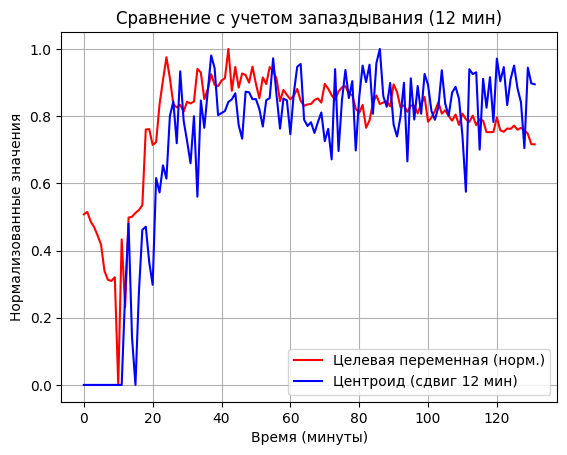

In [136]:
time = centroids_df['time']
plt.plot(time, target_norm, label='Целевая переменная (норм.)', color='red')
plt.plot(time, shifted_centroid, label=f'Центроид (сдвиг {optimal_lag} мин)', color='blue')
plt.xlabel('Время (минуты)')
plt.ylabel('Нормализованные значения')
plt.title(f'Сравнение с учетом запаздывания ({optimal_lag} мин)')
plt.legend()
plt.grid()

In [137]:
corr, p_value = pearsonr(target_norm, shifted_centroid)
print('Корреляция с учетом сдвига:', corr)
print('p-value:', p_value)

Корреляция с учетом сдвига: 0.8218254540901416
p-value: 1.4645154782987631e-33
